In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# Load the dataset
file_path = '../dataset/BodyFat - Extended.csv'
data = pd.read_csv(file_path)

data = data[data['Sex'] == 'M']

# Separate features and target variable
X = data[['Height', 'Neck', 'Abdomen']]
y = data["BodyFat"]

# Normalize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
joblib.dump(scaler, '../scalers/men_scaler.joblib')

['../scalers/men_scaler.joblib']

In [14]:
data

,BodyFat,Original,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,Y,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,Y,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,Y,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,Y,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,Y,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,11.0,Y,M,70,60.90,1.70,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,33.6,Y,M,72,91.17,1.77,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,29.3,Y,M,72,84.71,1.68,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,26.0,Y,M,72,86.52,1.79,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


In [15]:
checkpoint_filepath = '../models/men_best_model_weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_mean_absolute_error',
    mode='min',          # Save the model with minimum mean absolute error
    verbose=1
)

# Define the deep learning model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [16]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/100
 1/10 [==>...........................] - ETA: 6s - loss: 439.5993 - mean_absolute_error: 19.0396
Epoch 1: val_mean_absolute_error improved from inf to 13.32824, saving model to ../models/men_best_model_weights.h5
10/10 [==============================] - 1s 44ms/step - loss: 402.4182 - mean_absolute_error: 18.1547 - val_loss: 235.8602 - val_mean_absolute_error: 13.3282
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 194.9595 - mean_absolute_error: 12.2482
Epoch 2: val_mean_absolute_error improved from 13.32824 to 6.11903, saving model to ../models/men_best_model_weights.h5
10/10 [==============================] - 0s 17ms/step - loss: 174.9243 - mean_absolute_error: 10.0186 - val_loss: 53.4361 - val_mean_absolute_error: 6.1190
Epoch 3/100
 1/10 [==>...........................] - ETA: 0s - loss: 102.1940 - mean_absolute_error: 8.7918
Epoch 3: val_mean_absolute_error improved from 6.11903 to 6.06109, saving model to ../models/men_best_model_weights.h5
10/10

In [17]:
# Evaluate the model on the test set
model.load_weights(checkpoint_filepath)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Test Loss: 19.439302444458008
Test MAE: 3.134660243988037


80.39% of predictions have a difference of lower than three with actual values.


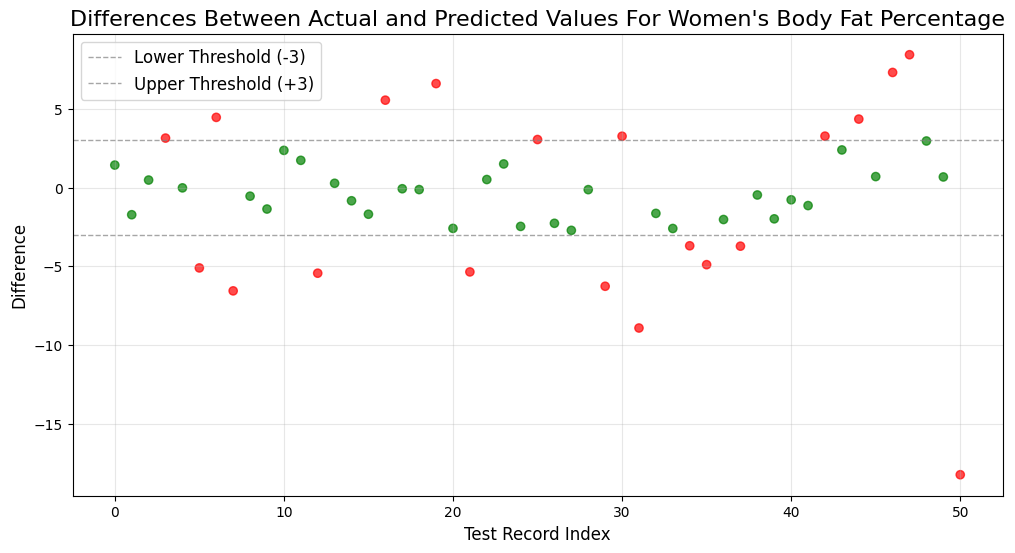

In [18]:
# Predict values for the test set
predicted_values = model.predict(X_test, verbose=0).flatten()
actual_values = y_test.values

# Calculate the differences (residuals)
differences = actual_values - predicted_values

lower_than_3 = 0
for diff in differences:
    if diff <= 3:
        lower_than_3 += 1
        
print(f'{lower_than_3 / len(differences) * 100:.2f}% of predictions have a difference of lower than three with actual values.')

# Define colors based on the threshold
colors = ['green' if -3 <= diff <= 3 else 'red' for diff in differences]

# Plot the differences as scatter points
plt.figure(figsize=(12, 6))
plt.scatter(range(len(differences)), differences, c=colors, alpha=0.7)
plt.axhline(y=-3, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Lower Threshold (-3)')
plt.axhline(y=3, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Upper Threshold (+3)')

# Add labels and legend
plt.title('Differences Between Actual and Predicted Values For Women\'s Body Fat Percentage', fontsize=16)
plt.xlabel('Test Record Index', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [19]:
# Select a random test record
test_index = np.random.randint(0, len(X_test))  # Random index from the test set
test_record = X_test[test_index].reshape(1, -1)  # Reshape for prediction
actual_value = y_test.iloc[test_index]  # Corresponding actual value

# Predict using the model
predicted_value = model.predict(test_record, verbose=0)

# Print the results
print(f"Predicted Body Fat Percentage: {predicted_value[0][0]:.2f}")
print(f"Actual Body Fat Percentage: {actual_value:.2f}")
print(f"Differece: {abs(predicted_value[0][0] - actual_value):.2f}")

Predicted Body Fat Percentage: 20.93
Actual Body Fat Percentage: 19.20
Differece: 1.73
